### Homework
Create your own dataset by selecting some classes from Caltech101
(or a different dataset, as you prefer), as shown in the video lecture.
Then, import a pretrained model and fine tune it to perform decently on your dataset.


**Solution.**

In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os

torch.manual_seed(15)

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.3, 0.3, 0.3])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.3, 0.3, 0.3])
    ]),
}

data_dir = 'data/Caltech101_subset2'
datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(datasets[x], batch_size=4, shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
class_names = datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

Device: cpu


In [3]:
print(dataloaders['train'].dataset)
print()
print(dataloaders['val'].dataset)

Dataset ImageFolder
    Number of datapoints: 446
    Root location: data/Caltech101_subset2/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.3, 0.3, 0.3])
           )

Dataset ImageFolder
    Number of datapoints: 88
    Root location: data/Caltech101_subset2/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.3, 0.3, 0.3])
           )


In [4]:
num_classes = 6 # len(class_na,es)

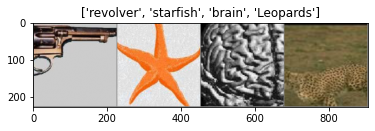

In [5]:
from utils.visual import imshow
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
from utils.training_helpers import train_model

# model = torchvision.models.resnet18(pretrained=True)
# model = torchvision.models.googlenet(pretrained=True) # Acc: 1.000000
model = torchvision.models.wide_resnet50_2(pretrained=True) # Acc: 1.000000
for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

model = train_model(model, criterion, optimizer,
                         exp_lr_scheduler, dataloaders, device, num_epochs=30)

Epoch 0/29
----------
val Loss: 0.5654 Acc: 0.8636

Epoch 3/29
----------
val Loss: 0.1727 Acc: 0.9659

Epoch 6/29
----------
val Loss: 0.1871 Acc: 0.9545

Epoch 9/29
----------
val Loss: 0.1110 Acc: 1.0000

Epoch 12/29
----------
val Loss: 0.1258 Acc: 0.9659

Epoch 15/29
----------
val Loss: 0.0982 Acc: 0.9886

Epoch 18/29
----------
val Loss: 0.0892 Acc: 0.9886

Epoch 21/29
----------
val Loss: 0.0852 Acc: 0.9886

Epoch 24/29
----------
val Loss: 0.0764 Acc: 0.9886

Epoch 27/29
----------
val Loss: 0.0719 Acc: 1.0000

Training complete in 168m 13s
Best val Acc: 1.000000


Now we fine tune all the model.

In [7]:
ignored_params = list(map(id, model.fc.parameters()))
base_params = filter(lambda p: id(p) not in ignored_params, model.parameters())

for param in base_params:
    param.requires_grad = True


optimizer = torch.optim.SGD([
            {'params': base_params}, # all the other parameters
            {'params': model.fc.parameters(), 'lr': 1e-3}], # last layer parameterers
            lr=5e-4, momentum=0.9)

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

model = train_model(model, criterion, optimizer,
                         exp_lr_scheduler, dataloaders, device, num_epochs=20)

Epoch 0/19
----------
val Loss: 0.1058 Acc: 0.9773

Epoch 2/19
----------
val Loss: 0.1367 Acc: 0.9318

Epoch 4/19
----------
val Loss: 0.1181 Acc: 0.9773

Epoch 6/19
----------
val Loss: 0.0935 Acc: 0.9773

Epoch 8/19
----------
val Loss: 0.1187 Acc: 0.9886

Epoch 10/19
----------
val Loss: 0.0918 Acc: 0.9773

Epoch 12/19
----------
val Loss: 0.1093 Acc: 0.9886

Epoch 14/19
----------
val Loss: 0.1018 Acc: 0.9659

Epoch 16/19
----------
val Loss: 0.0966 Acc: 0.9886

Epoch 18/19
----------
val Loss: 0.0729 Acc: 1.0000

Training complete in 459m 40s
Best val Acc: 1.000000


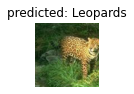

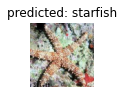

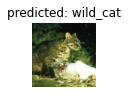

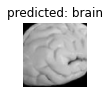

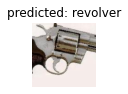

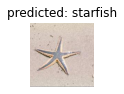

In [8]:
from utils.visual import visualize_model
visualize_model(model, device, dataloaders, class_names)

plt.show()

In [9]:
torch.save(model.state_dict(), 'saved_models/finetuned_wide_resnet50_2_caltechCBE2.pt')